# 1. CNOT Binary Tree Fan-Out for GHZ State Generation

The generalized GHZ state in a $N$-qubit Hilbert space is defined as

$$ \ket{GHZ} = \frac{\ket{0}^{\otimes N} + \ket{1}^{\otimes N}}{\sqrt{2}}.$$

## Quick Summary

- Naive GHZ state preparation in a $N$-qubit system requires a circuit depth of $\mathcal{O}(N)$
- Using CNOT binary tree fan-out and assuming ideal qubit connectivity, the circuit depth can in principle be reduced to $\mathcal{O}(\text{log}_2(N))$ by parallelizing the required CNOT gates
- We implement optimal CNOT binary tree fan-out for GHZ state generation given a graph of any IBM backend
- We demonstrate significant reduction of the two-qubit gate circuit depth for GHZ state generation comparing our method to the Qiskit transpiler result (up to 80 %)
- On Torino backend two-qubit gate depth can be reduced to scale as $\mathcal{O}(\sqrt{N})$

## Introduction
Starting with the initial state $\ket{0 \dotsm 0}$, the GHZ state can be deterministically prepared with the following circuit:

In [2]:
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeOslo, FakeSingaporeV2
from qiskit_ibm_runtime import SamplerV2
from qiskit.transpiler import generate_preset_pass_manager
import networkx as nx
import numpy as np
from qiskit import QuantumCircuit, transpile

/Users/samizweidler/Documents/ETH/4_6_Master/6.Jahr/Qiskit_Hackathon_June/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


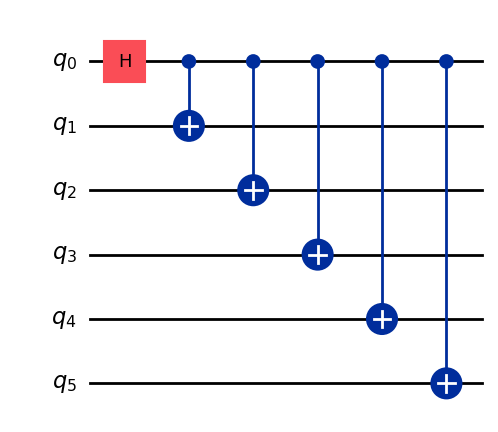

In [3]:
# example for n=6 qubits

def naive_ghz_V1(n=6):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n - 1):
        qc.cx(0, i + 1)
    return qc

qc1 = naive_ghz_V1()
qc1.draw('mpl')

This circuit can be rewritten as follows (still considering the initial state $\ket{0 \dotsm 0}$)

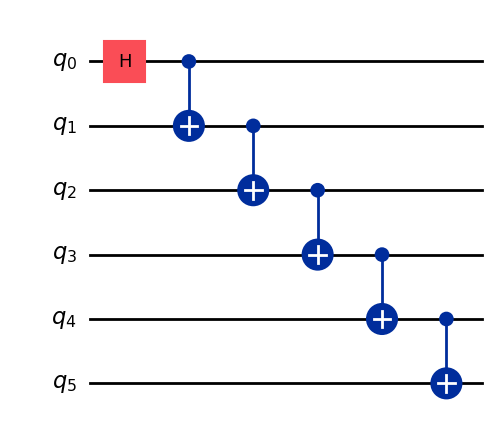

In [4]:
# example for n=6 qubits

def naive_ghz_V2(n=6):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n - 1):
        qc.cx(i, i + 1)
    return qc

qc2 = naive_ghz_V2()
qc2.draw('mpl')

The latter circuit is compatible with a QPU geometry with only two nearest neighbours per qubit, i.e. with any IBM Quantum Backend.

## Idea: CNOT Binary Tree Fan-Out

In both examplary circuits, we recognize that we can rewrite them also in the following way

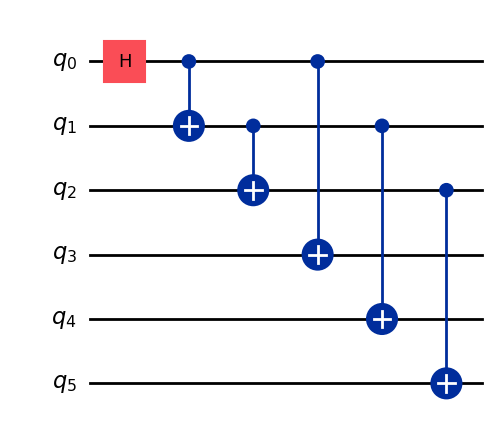

In [5]:
qc3 = QuantumCircuit(6)

qc3.h(0)
qc3.cx(0, 1)
qc3.cx(1, 2)
qc3.cx(0, 3)
qc3.cx(1, 4)
qc3.cx(2, 5)

qc3.draw('mpl')

Notably, the last three CNOT gates can be implemented in parallel, reducing the 2Q-circuit depth from 5 to 3 in this example. 

This parrallelization strategy (CNOT binary tree fan-out) can be generalized to efficiently generate GHZ in a many-qubit system. The number of CNOT gates that can be executed in parallel grows as $3 \cdot 2^{M}$ for every step, which leads to a circuit depth that is logarithmic in the number of qubits $N$.

## Implementation

The fan-out strategy described above ideally requires exponentially growing qubit connectivity. To adapt the strategy for a given IBM backend, we constantly evaluate all non-entangled nearest neighbours in qubit connectivity graph and maximally parallelize the CNOT gate execution.

In [6]:
def optimized_ghz_circuit(n, backend):

    coupling = backend.configuration().coupling_map  # List of [control, target] edges

    # Convert to networkx.Graph
    G = nx.Graph()
    G.add_edges_from(coupling)

    seen = set()

    qc = QuantumCircuit(len(G.nodes))

    qc.h(0)  # Apply Hadamard to the first qubit
    seen.add(0)
    boundary = {0}
    while len(seen) < n:
        new_boundary = set()
        for i in boundary:
            for j in G.neighbors(i):
                if j not in seen:
                    qc.cx(i, j)
                    seen.add(j)
                    new_boundary.add(j)
        boundary = new_boundary
    
    return qc

## Evaluation

Evaluate how the two-qubit gate circuit depth scales with the number of qubits that are part of the GHZ state. (RUNS 2 min.)

In order to spare time, we stored the computed depths in lists (set run_eval to False)

Compute naive circuit V1, naive circuit V2, and optimized circuit employing the fan-out strategy. Transpile all circuits. Evaluate two-qubit gate depth for all transpiled circuits.

In [ ]:
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit_ibm_runtime import SamplerV2
from qiskit.transpiler import generate_preset_pass_manager

n_list = np.arange(3,31) 

two_Q_depth_1 = []
two_Q_depth_2 = []
two_Q_depth_3 = []

run_eval = False

if run_eval:
    for n in n_list:
    
        backend = FakeTorino() 

        # naive 1
        qc1 = naive_ghz_V1(n)

        # naive 2
        qc2 = naive_ghz_V2(n)

        # optimized
        qc3 = optimized_ghz_circuit(n, backend)

        # transpile
        qc1_t = transpile(qc1, backend=backend, optimization_level=3)
        qc2_t = transpile(qc2, backend=backend, optimization_level=3)
        qc3_t = transpile(qc3, backend=backend, optimization_level=3)

        two_Q_depth_1.append(qc1_t.depth(lambda op: len(op.qubits) == 2))
        two_Q_depth_2.append(qc2_t.depth(lambda op: len(op.qubits) == 2))
        two_Q_depth_3.append(qc3_t.depth(lambda op: len(op.qubits) == 2))

else:
    # Precomputed values for two-qubit gate depths
    two_Q_depth_1 = [2, 3, 7, 11, 14, 16, 17, 22, 24, 33, 32, 36, 38, 44, 41, 47, 37, 53, 53, 56, 61, 71, 72, 74, 75, 89, 86, 83]
    two_Q_depth_2 = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
    two_Q_depth_3 = [2, 3, 3, 4, 4, 5, 5, 7, 7, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11, 11, 11, 11, 13, 13, 13, 13, 13, 13]

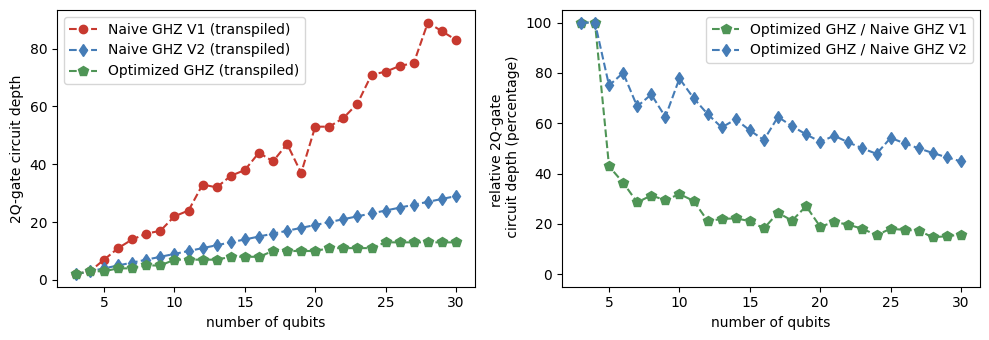

In [14]:
import matplotlib.pyplot as plt

red = (199/255, 57/255, 47/255)
blue = (69/255, 124/255, 182/255)
green = (79/255, 149/255, 86/255)
purple = (151/255, 142/255, 208/255)


fig, ax = plt.subplots(1,2, figsize=(10, 3.5))

ax[0].plot(n_list, two_Q_depth_1, label='Naive GHZ V1 (transpiled)', marker='o', color = red, linestyle= 'dashed', markersize=6)
ax[0].plot(n_list, two_Q_depth_2, label='Naive GHZ V2 (transpiled)', marker='d', color = blue, linestyle= 'dashed', markersize=6)
ax[0].plot(n_list, two_Q_depth_3, label='Optimized GHZ (transpiled)', marker='p', color = green, linestyle= 'dashed', markersize=7)
# reduction in depth (percentage)

ax[1].plot(n_list, np.array(two_Q_depth_3) / np.array(two_Q_depth_1)*100, label='Optimized GHZ / Naive GHZ V1', marker='p', color = green, linestyle= 'dashed', markersize=7)
ax[1].plot(n_list, np.array(two_Q_depth_3) / np.array(two_Q_depth_2)*100, label='Optimized GHZ / Naive GHZ V2', marker='d', color = blue, linestyle= 'dashed', markersize=6)



ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=2, fancybox=True, shadow=True)

ax[0].set_xlabel('number of qubits')
ax[0].set_ylabel('2Q-gate circuit depth')
ax[0].legend()

ax[1].set_xlabel('number of qubits')
ax[1].set_ylabel('relative 2Q-gate \n circuit depth (percentage)')
ax[1].legend()

ax[1].set_ylim(-5, 105)

fig.set_tight_layout(True)
fig.savefig('ghz_depths.png', bbox_inches='tight', dpi = 400)

# Results

- Development of a pre-processing step that optimizes the circuit specific to GHZ state generation on a given IBM backend
- Employs CNOT binary tree fan-out reducing two-qubit gate circuit depth significantly below $\mathcal{O}(N)$ for $N$ qubits
- Lower bound for two-qubit gate circuit depth: $\mathcal{O}(\text{log}_2(N))$; attained for optimal qubit connectivity on QPU
- Two-qubit circuit depth scales like $\mathcal{O}(\sqrt{N})$ on a square lattice
- Demonstrated reduction of two-qubit gate circuit depth of up to 80 % (for N = 30 and comparing the optimized GHZ circuit to the V1 circuit)
- Methodology can be generalized to other CNOT ladder circuit structures

# 2. 